In [ ]:
#!pip -q install /pstore/home/shetabs1/code/iflai/

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import skorch
import torch
from skorch import NeuralNetClassifier
from tqdm import tqdm
from torchvision import transforms
import torch.nn as nn
from scipy.stats import entropy
import random
import h5py
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import FeatureAgglomeration

In [3]:
from scifAI.dl.utils import train_validation_test_split
from scifAI.dl.dataset import DatasetGenerator
from scifAI.dl.utils import get_statistics

In [4]:
from scifAI.dl.models import PretrainedModel
from skorch.callbacks import LRScheduler,Checkpoint,EpochScoring,EarlyStopping
import torch.optim as optim
from skorch.helper import predefined_split

In [5]:


# Compare Algorithms
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.semi_supervised import LabelPropagation
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

In [6]:
from sklearn.random_projection import GaussianRandomProjection

In [7]:
import torch
import torchvision
from torch import nn

from lightly.data import LightlyDataset
from lightly.data.multi_view_collate import MultiViewCollate
from lightly.loss import BarlowTwinsLoss
from lightly.models.modules import BarlowTwinsProjectionHead
from lightly.transforms.simclr_transform import SimCLRTransform

In [8]:
from sklearn.metrics import plot_confusion_matrix, matthews_corrcoef, classification_report,confusion_matrix, accuracy_score, balanced_accuracy_score, cohen_kappa_score, f1_score,  precision_score, recall_score
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay


def classification_complete_report(y_true, y_pred ,labels = None  ): 
    print(classification_report(y_true, y_pred, labels = labels))
    print(15*"----")
    print("matthews correlation coeff: %.4f" % (matthews_corrcoef(y_true, y_pred)) )
    print("Cohen Kappa score: %.4f" % (cohen_kappa_score(y_true, y_pred)) )
    print("Accuracy: %.4f & balanced Accuracy: %.4f" % (accuracy_score(y_true, y_pred), balanced_accuracy_score(y_true, y_pred)) )
    print("macro F1 score: %.4f & micro F1 score: %.4f" % (f1_score(y_true, y_pred, average = "macro"), f1_score(y_true, y_pred, average = "micro")) )
    print("macro Precision score: %.4f & micro Precision score: %.4f" % (precision_score(y_true, y_pred, average = "macro"), precision_score(y_true, y_pred, average = "micro")) )
    print("macro Recall score: %.4f & micro Recall score: %.4f" % (recall_score(y_true, y_pred, average = "macro"), recall_score(y_true, y_pred, average = "micro")) )
    cm = confusion_matrix(y_true, y_pred,labels= labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()
    print(15*"----")

In [9]:
metadata = pd.read_csv("/projects/site/pred/data_science/year/2022/immunological_synapse/synapse_data_features/metadata_subset.csv.gz")
metadata.file = metadata.file.astype(str)

metadata.file = metadata.file.str.replace("/pstore/data/DS4/synapse_formation_full_data/",
                          "/projects/site/pred/data_science/year/2022/immunological_synapse/synapse_formation_full_data/", regex=True)

metadata

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,file,experiment,donor,condition,object_number,set,label
0,/projects/site/pred/data_science/year/2022/imm...,Experiment_1,Donor_1,+SEA,5156,unlabeled,-1
1,/projects/site/pred/data_science/year/2022/imm...,Experiment_1,Donor_1,+SEA,32020,unlabeled,-1
2,/projects/site/pred/data_science/year/2022/imm...,Experiment_1,Donor_1,+SEA,55974,unlabeled,-1
3,/projects/site/pred/data_science/year/2022/imm...,Experiment_1,Donor_1,+SEA,15150,unlabeled,-1
4,/projects/site/pred/data_science/year/2022/imm...,Experiment_1,Donor_1,+SEA,44814,unlabeled,-1
...,...,...,...,...,...,...,...
1065962,/projects/site/pred/data_science/year/2022/imm...,Experiment_4,Donor_9,DIG-TCB,72493,unlabeled,-1
1065963,/projects/site/pred/data_science/year/2022/imm...,Experiment_4,Donor_9,DIG-TCB,106656,unlabeled,-1
1065964,/projects/site/pred/data_science/year/2022/imm...,Experiment_4,Donor_9,DIG-TCB,110990,unlabeled,-1
1065965,/projects/site/pred/data_science/year/2022/imm...,Experiment_4,Donor_9,DIG-TCB,71451,unlabeled,-1


In [10]:
metadata.set.unique()

array(['unlabeled', 'labeled', 'train', 'test', 'validation'],
      dtype=object)

In [11]:
indx = metadata.condition.isin(["-SEA","+SEA"])
metadata = metadata.loc[indx, :].reset_index(drop = True )

In [12]:
set_of_interesting_classes = ['B_cell',  
                              'T_cell', 
                              'T_cell_with_signaling',
                              'T_cell_with_B_cell_fragments',
                              'B_T_cell_in_one_layer',
                              'Synapses_without_signaling', 
                              'Synapses_with_signaling',
                              'No_cell_cell_interaction',
                              'Multiplets']

In [13]:
metadata["set"].unique()

array(['unlabeled', 'labeled', 'train', 'test', 'validation'],
      dtype=object)

In [14]:
unlabeled_index = metadata["set"] == "unlabeled"
unlabeled_index = unlabeled_index[unlabeled_index].index

 
labeled_index = metadata["label"].isin(set_of_interesting_classes)

train_index = metadata["set"] == "train"
train_index = train_index & labeled_index
train_index = train_index[train_index].index

validation_index = metadata["set"] == "validation"
validation_index = validation_index & labeled_index
validation_index = validation_index[validation_index].index

test_index = metadata["set"] == "test"
test_index = test_index & labeled_index
test_index = test_index[test_index].index

In [15]:
 len(unlabeled_index)

417131

In [16]:


label_map = dict()
for i, cl in enumerate(set_of_interesting_classes):
    label_map[cl] = i

label_map['-1'] = -1
label_map[-1] = -1

print("Number of labeled images",labeled_index.sum())

Number of labeled images 5221


In [17]:
label_map

{'B_cell': 0,
 'T_cell': 1,
 'T_cell_with_signaling': 2,
 'T_cell_with_B_cell_fragments': 3,
 'B_T_cell_in_one_layer': 4,
 'Synapses_without_signaling': 5,
 'Synapses_with_signaling': 6,
 'No_cell_cell_interaction': 7,
 'Multiplets': 8,
 '-1': -1,
 -1: -1}

In [18]:
channels = {
     "Ch1": ("Greys", "BF"),  
     "Ch2": ("Greens", "Antibody"),
     "Ch3": ("Reds", "CD18"),
     "Ch4": ("Oranges", "F-Actin"),
     "Ch6": ("RdPu", "MHCII"),
     "Ch7": ("Purples", "CD3/CD4"),
     "Ch11": ("Blues", "P-CD3zeta"),
     "Ch12": ("Greens", "Live-Dead")
 }

In [19]:
reshape_size = 160
selected_channels = [0,3,4,5,6]

stats = dict()

stats["lower_bound"] = torch.tensor([756.5198,52.5891,45.7574,54.1436,39.0545])
stats["upper_bound"] = torch.tensor([835.3564,288.1139,271.3861,234.2525,90.0396])

In [20]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [21]:
class MinMaxScaler(object):
    def __init__(self, min_in , max_in, min_out, max_out):
        self.min_in = min_in.reshape(-1,1,1)
        self.max_in = max_in.reshape(-1,1,1)
        self.min_out = min_out
        self.max_out = max_out
        
    def __call__(self, tensor):
        
        tensor_ = (tensor - self.min_in)/(self.max_in - self.min_in)
        tensor_ = tensor_*(self.max_out - self.min_out) + self.min_out
        tensor_[tensor_<self.min_out]= self.min_out
        tensor_[tensor_>self.max_out]= self.max_out
        return tensor_
    
    def __repr__(self):
        return self.__class__.__name__ + '(min_out={0}, max_out={1})'.format(self.min_out, self.max_out)

## pretraining

In [22]:
from torch.utils.data import Dataset
import numpy as np
import h5py
from skimage.util import crop
import copy
import os



def get_image(h5_file_path, scaling_factor):
    h5_file = h5py.File(h5_file_path, 'r')
    image_original =h5_file.get('image')[()] / scaling_factor
    h5_file.close()
    h5_file = None
    return image_original

def crop_pad_h_w(image_dummy, reshape_size):
    if image_dummy.shape[0] < reshape_size:
        h1_pad = (reshape_size - image_dummy.shape[0]) / 2
        h1_pad = int(h1_pad)
        h2_pad = reshape_size - h1_pad - image_dummy.shape[0]
        h1_crop = 0
        h2_crop = 0
    else:
        h1_pad = 0
        h2_pad = 0
        h1_crop = (reshape_size - image_dummy.shape[0]) / 2
        h1_crop = abs(int(h1_crop))
        h2_crop = image_dummy.shape[0] - reshape_size - h1_crop

    if image_dummy.shape[1] < reshape_size:
        w1_pad = (reshape_size - image_dummy.shape[1]) / 2
        w1_pad = int(w1_pad)
        w2_pad = reshape_size - w1_pad - image_dummy.shape[1]
        w1_crop = 0
        w2_crop = 0
    else:
        w1_pad = 0
        w2_pad = 0
        w1_crop = (reshape_size - image_dummy.shape[1]) / 2
        w1_crop = abs(int(w1_crop))
        w2_crop = image_dummy.shape[1] - reshape_size - w1_crop

    h = [h1_crop, h2_crop, h1_pad, h2_pad]
    w = [w1_crop, w2_crop, w1_pad, w2_pad]
    return h, w


class DatasetGeneratorBarlowTwins(Dataset):

    def __init__(self,
                metadata,
                label_map,
                selected_channels,
                reshape_size=64,
                scaling_factor = 4095.,
                transform=None):

        self.metadata = metadata.copy().reset_index(drop = True)
        self.selected_channels = selected_channels
        self.num_channels = len(self.selected_channels)
        self.reshape_size = reshape_size
        self.label_map = label_map
        self.transform = transform
        self.scaling_factor = scaling_factor

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()

        ## get image and label
        h5_file_path = self.metadata.loc[idx,"file"]
        image_original= get_image(h5_file_path, self.scaling_factor)
        label = self.metadata.loc[idx,"label"]

        ## creating the image
        h, w = crop_pad_h_w(image_original, self.reshape_size)
        h1_crop, h2_crop, h1_pad, h2_pad = h
        w1_crop, w2_crop, w1_pad, w2_pad = w
        image = np.zeros((  self.num_channels,
                            self.reshape_size,
                            self.reshape_size),
                            dtype=np.float64)

        # filling the image with selected channels
        for i, ch in enumerate(self.selected_channels):
            image_dummy = crop( image_original[:, :, ch],
                                ((h1_crop, h2_crop),
                                (w1_crop, w2_crop)))
            image_dummy = np.pad(image_dummy,
                                ((h1_pad, h2_pad),(w1_pad, w2_pad)),
                                "constant",
                                constant_values = image_dummy.mean())
            image[i, :, :] = image_dummy
            image_dummy = None

        image_original = None

        # map numpy array to tensor
        image = torch.from_numpy(copy.deepcopy(image))

        if self.transform:
            image1 = self.transform(image)
            image2 = self.transform(image)


        label = self.label_map[label]
        label = torch.tensor(label).long()
        return image1.float(), image2.float(), label

In [23]:
train_transform = transforms.Compose([ 
        MinMaxScaler(           min_in =  stats["lower_bound"] , 
                                max_in =  stats["upper_bound"] , 
                                min_out =  0. , 
                                max_out =  1.),
        transforms.RandomResizedCrop(reshape_size, scale=(0.4, 1.2), ratio=(0.7, 1.3)),
        transforms.RandomRotation(45),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomErasing(),
        AddGaussianNoise(mean=0., std=0.10),
])



unlabeled_dataset = DatasetGeneratorBarlowTwins(metadata.loc[unlabeled_index.tolist(),:], 
                                             reshape_size=reshape_size, 
                                             scaling_factor = 1.,
                                            label_map=label_map, 
                                             transform = train_transform,
                                            selected_channels=selected_channels)

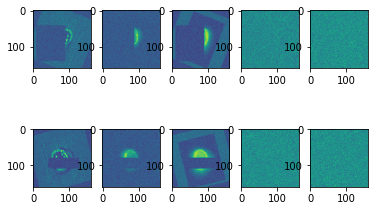

In [24]:
fig, ax = plt.subplots(ncols=5,nrows=2)

x0,x1,_=unlabeled_dataset[0]

for j in range(5):
    ax[0,j].imshow(x0[j,:,:])
    ax[1,j].imshow(x1[j,:,:])

In [25]:
class BarlowTwins(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.projection_head = BarlowTwinsProjectionHead(512, 2048, 2048)

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(x)
        return z

In [26]:
import torch.nn as nn
from torchvision.models import resnet152, resnet18, resnet34, resnet50
import torch.nn.functional as F

backbone =  resnet34(weights='IMAGENET1K_V1')
num_channels = len(selected_channels)
num_classes = len(set_of_interesting_classes)
if num_channels != 3:
    backbone.conv1 = nn.Conv2d(num_channels, 64, kernel_size=(7, 7),
                                    stride=(2, 2), padding=(3, 3), bias=False)
num_ftrs = backbone.fc.in_features
backbone.fc = nn.Linear(num_ftrs, num_classes)
backbone = nn.Sequential(*list(backbone.children())[:-1])

In [27]:

barlow_twins = BarlowTwins(backbone)


    
device = "cuda" if torch.cuda.is_available() else "cpu"
barlow_twins.to(device);
barlow_twins = torch.nn.DataParallel(barlow_twins)

try:
    barlow_twins.load_state_dict(torch.load("BarlowTwins_data_parallel.pt"))
    print("Barlow twins weights are loaded")
except:
    print("could not load the weights")

Barlow twins weights are loaded


In [28]:
dataloader = torch.utils.data.DataLoader(
    unlabeled_dataset,
    batch_size=1024,
    shuffle=True,
    drop_last=False,
    num_workers=20,
)

In [29]:
criterion = BarlowTwinsLoss()
optimizer = torch.optim.Adam(barlow_twins.parameters(), lr=0.001)

In [30]:
print("Starting Training")
for epoch in range(15):
    total_loss = 0
    for x0, x1, _ in tqdm(dataloader, position=0, leave=True):
        x0 = x0.to(device)
        x1 = x1.to(device)
        z0 = barlow_twins(x0)
        z1 = barlow_twins(x1)
        loss = criterion(z0, z1)
        total_loss += loss.detach()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    avg_loss = total_loss / len(dataloader)
    torch.save(barlow_twins.state_dict(), "BarlowTwins_data_parallel.pt")
    print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")
    torch.cuda.empty_cache()

Starting Training


100%|██████████| 408/408 [11:13<00:00,  1.65s/it]


epoch: 00, loss: 20.07923


100%|██████████| 408/408 [07:31<00:00,  1.11s/it]


epoch: 01, loss: 20.02024


100%|██████████| 408/408 [07:30<00:00,  1.10s/it]


epoch: 02, loss: 20.00659


100%|██████████| 408/408 [07:02<00:00,  1.03s/it]


epoch: 03, loss: 20.00890


100%|██████████| 408/408 [07:20<00:00,  1.08s/it]


epoch: 04, loss: 20.00165


100%|██████████| 408/408 [07:17<00:00,  1.07s/it]


epoch: 05, loss: 19.95423


100%|██████████| 408/408 [04:54<00:00,  1.39it/s]


epoch: 06, loss: 19.96600


100%|██████████| 408/408 [04:57<00:00,  1.37it/s]


epoch: 07, loss: 19.96584


100%|██████████| 408/408 [04:54<00:00,  1.39it/s]


epoch: 08, loss: 19.96573


100%|██████████| 408/408 [05:24<00:00,  1.26it/s]


epoch: 09, loss: 19.92742


100%|██████████| 408/408 [05:17<00:00,  1.28it/s]


epoch: 10, loss: 19.97234


100%|██████████| 408/408 [04:59<00:00,  1.36it/s]


epoch: 11, loss: 20.14592


100%|██████████| 408/408 [05:47<00:00,  1.17it/s]


epoch: 12, loss: 20.16381


100%|██████████| 408/408 [05:09<00:00,  1.32it/s]


epoch: 13, loss: 20.21768


100%|██████████| 408/408 [05:04<00:00,  1.34it/s]


epoch: 14, loss: 20.17061


In [31]:
torch.save(barlow_twins.module.state_dict(), "BarlowTwins.pt")